In [1]:
import os
import gc
import pickle
import numpy as np; np.random.seed(7)
import pandas as pd
import lightgbm as lgb
from tqdm import tqdm
from tsforest.forecaster import LightGBMForecaster

import matplotlib.pyplot as plt
import seaborn as sns

# local modules
import sys
sys.path.append("../lib/")
from utils import compute_scaling, reduce_mem_usage, find_out_of_stock
from evaluation import Evaluator

/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


***

In [2]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .reset_index(drop=True)
        .rename({"q":"y"}, axis=1)
       )

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45942500 entries, 0 to 45942499
Data columns (total 35 columns):
 #   Column             Dtype         
---  ------             -----         
 0   ts_id              int16         
 1   item_id            int16         
 2   dept_id            int8          
 3   cat_id             int8          
 4   store_id           int8          
 5   state_id           int8          
 6   y                  int16         
 7   ds                 datetime64[ns]
 8   event_name_1       int8          
 9   event_type_1       int8          
 10  event_name_2       int8          
 11  event_type_2       int8          
 12  sell_price         float32       
 13  n_prices           float32       
 14  regular_price      float32       
 15  price_iqr1         float32       
 16  price_iqr2         float32       
 17  price_min          float32       
 18  price_max          float32       
 19  discount           float32       
 20  discount_norm      flo

****

In [4]:
#weights_level12 = pd.read_parquet("../input/weights_level12.parquet")
#weights_level12.head()   

#scaling_input = pd.read_parquet("../input/scaling_input.parquet")
#scales = compute_scaling(scaling_input, agg_columns=["store_id","item_id"]).rename({"q":"s"}, axis=1)
#scales.head()

***
### finding time series with few samples

In [5]:
#ts_with_few_samples = (data
#                       .groupby(["item_id","store_id"])["ds"]
#                       .count()
#                       .reset_index(name="n_samples")
#                       .query("n_samples < 29")
#)
#ts_with_few_samples.head()

#few_samples_data = (data
#                    .merge(ts_with_few_samples.loc[:, ["item_id","store_id"]], how="left", indicator=True)
#                    .query("_merge == 'both'")
#                    .drop("_merge", axis=1)
#                    .reset_index(drop=True)
#                   )

#data = (data
#        .merge(ts_with_few_samples.loc[:, ["item_id","store_id"]], how="left", indicator=True)
#        .query("_merge == 'left_only'")
#        .drop("_merge", axis=1)
#        .reset_index(drop=True)
#       )

***

In [6]:
def make_valid_periods(end_date, valid_length, n_folds):
    right_date = pd.to_datetime(end_date)
    valid_periods = list()
    
    for i in range(n_folds):
        left_date = right_date - pd.DateOffset(days=valid_length-1)
        valid_periods.append((left_date, right_date))
        right_date = left_date - pd.DateOffset(days=1)
    
    return valid_periods[::-1]

In [7]:
#valid_periods = make_valid_periods("2016-04-24", valid_length=28, n_folds=13)
valid_periods = [(pd.to_datetime("2015-04-25"), pd.to_datetime("2015-05-22")),
                 (pd.to_datetime("2015-05-23"), pd.to_datetime("2015-06-20")), 
                 #(pd.to_datetime("2015-06-20"), pd.to_datetime("2015-07-17"))
                 #(pd.to_datetime("2016-03-28"), pd.to_datetime("2016-04-24"))
                ]
valid_periods

[(Timestamp('2015-04-25 00:00:00'), Timestamp('2015-05-22 00:00:00')),
 (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-20 00:00:00'))]

***
## training

In [8]:
model_params = {
    'objective':'tweedie',
    'tweedie_variance_power': 1.1,
    'metric':'None',
    'num_iterations':100000,
    'early_stopping_rounds':300,
    'max_bin': 127,
    'bin_construct_sample_cnt':6000000,
    'num_leaves': 2**10-1,
    'min_data_in_leaf': 2**11-1,
    'learning_rate': 0.05, 
    #'min_sum_hessian_in_leaf':1e-4,
    'feature_fraction': 0.9,
    #'feature_fraction_bynode':0.9,
    'bagging_fraction':0.66,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'seed':7,
    'boost_from_average': False,
    'first_metric_only': True,
}

time_features = [
    "year",
    "month",
    "year_week",
    #"year_day",
    "week_day",
    "month_progress", 
    #"week_day_cos",
    #"week_day_sin",
    #"year_day_cos",
    #"year_day_sin",
    #"year_week_cos",
    #"year_week_sin",
    #"month_cos",
    #"month_sin"
]

exclude_features = [
                    #"n_prices",
                    #"price_iqr1",
                    #"price_iqr2",
                    #"price_min",
                    #"price_max",
                    #"price_momentum_q",
                    #"price_momentum_s",
                    "store_id",
                    "state_id",
                    "ts_id",
                    "event_type_1",
                    "event_name_2",
                    "event_type_2"]

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "lags": list(range(1,15)),
    "window_shifts":[1,7,28],
    "window_functions":["mean","std"],
    "window_sizes":[7,28],
    "exclude_features":exclude_features,
    "categorical_features":{#"ts_id":"default",
                            "item_id":"default", 
                            "dept_id":"default",
                            "cat_id":"default",
                            "event_name_1":"default", 
                            #"event_type_1":"default", 
                            #"event_name_2":"default", 
                            #"event_type_2":"default",
                            "snap":"default"},
    "ts_uid_columns":["item_id"]
}

***
### Training validation models

In [9]:
# 5 years of history
train_history = 1825

############################################### 1/2 ################################################
##### Validation period: (Timestamp('2015-04-25 00:00:00'), Timestamp('2015-05-22 00:00:00')) ######
####################################################################################################
Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsseL12: 0.734657	valid_0's wrmsse: 0.835988
[50]	valid_0's wrmsseL12: 0.676651	valid_0's wrmsse: 0.519275
[75]	valid_0's wrmsseL12: 0.670444	valid_0's wrmsse: 0.489895
[100]	valid_0's wrmsseL12: 0.667655	valid_0's wrmsse: 0.475283
[125]	valid_0's wrmsseL12: 0.667739	valid_0's wrmsse: 0.472267
[150]	valid_0's wrmsseL12: 0.667853	valid_0's wrmsse: 0.470583
[175]	valid_0's wrmsseL12: 0.667624	valid_0's wrmsse: 0.467537
[200]	valid_0's wrmsseL12: 0.667207	valid_0's wrmsse: 0.465405
[225]	valid_0's wrmsseL12: 0.666969	valid_0's wrmsse: 0.462844
[250]	valid_0's wrmsseL12: 0.666783	valid_0's wrmsse: 0.460719
[275]	va

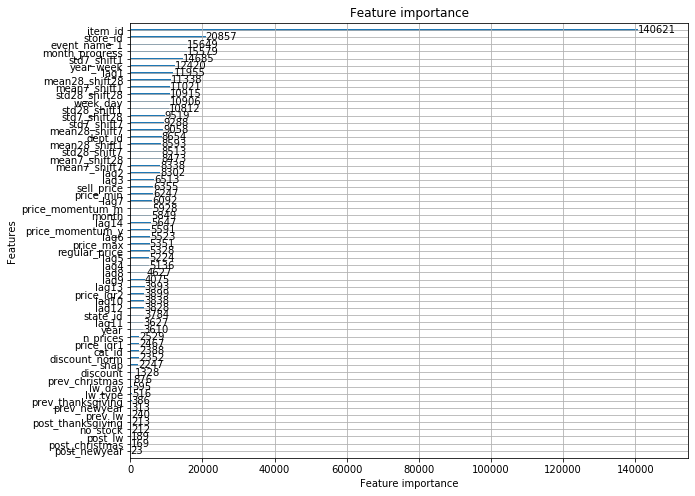

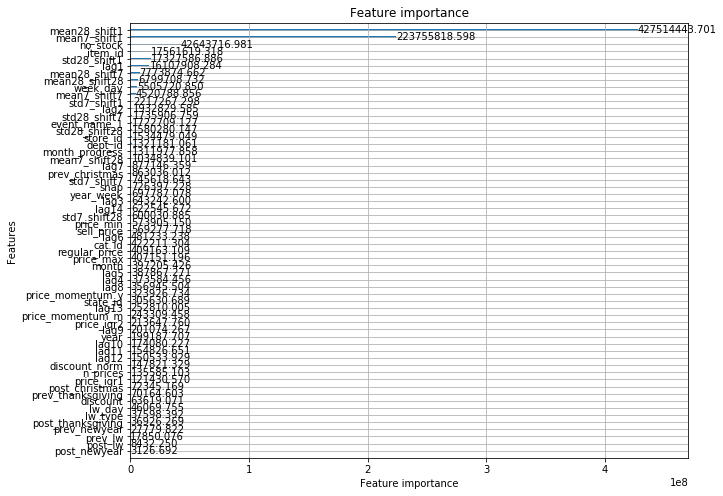

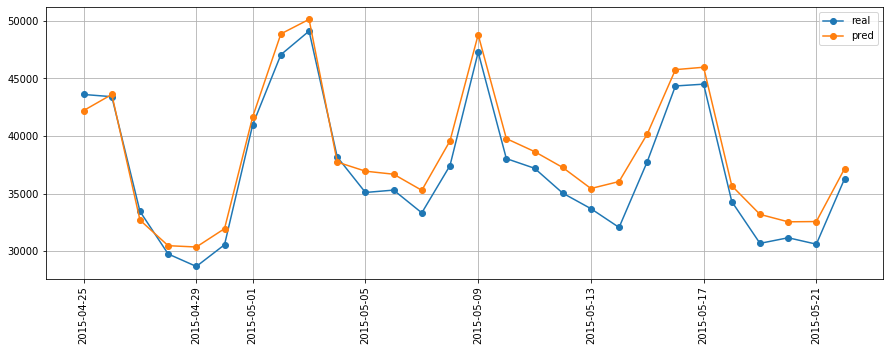

############################################### 2/2 ################################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-20 00:00:00')) ######
####################################################################################################
Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsseL12: 0.742415	valid_0's wrmsse: 0.889525
[50]	valid_0's wrmsseL12: 0.685616	valid_0's wrmsse: 0.594645
[75]	valid_0's wrmsseL12: 0.679216	valid_0's wrmsse: 0.556639
[100]	valid_0's wrmsseL12: 0.676845	valid_0's wrmsse: 0.537663
[125]	valid_0's wrmsseL12: 0.676814	valid_0's wrmsse: 0.533019
[150]	valid_0's wrmsseL12: 0.676459	valid_0's wrmsse: 0.527796
[175]	valid_0's wrmsseL12: 0.67642	valid_0's wrmsse: 0.526367
[200]	valid_0's wrmsseL12: 0.676084	valid_0's wrmsse: 0.521409
[225]	valid_0's wrmsseL12: 0.675651	valid_0's wrmsse: 0.518735
[250]	valid_0's wrmsseL12: 0.675165	valid_0's wrmsse: 0.516013
[275]	val

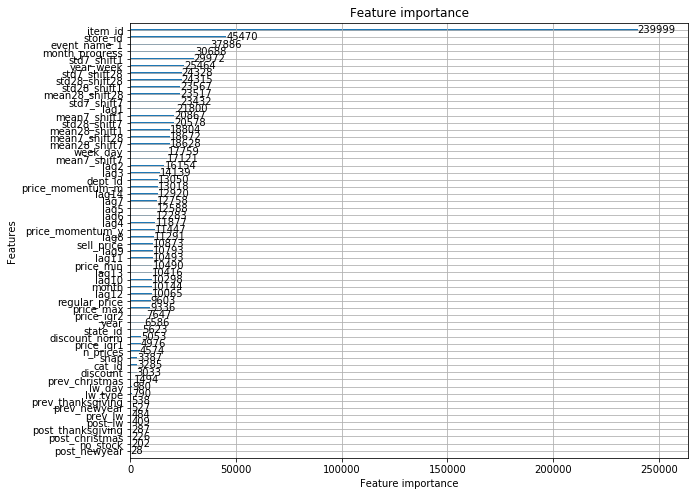

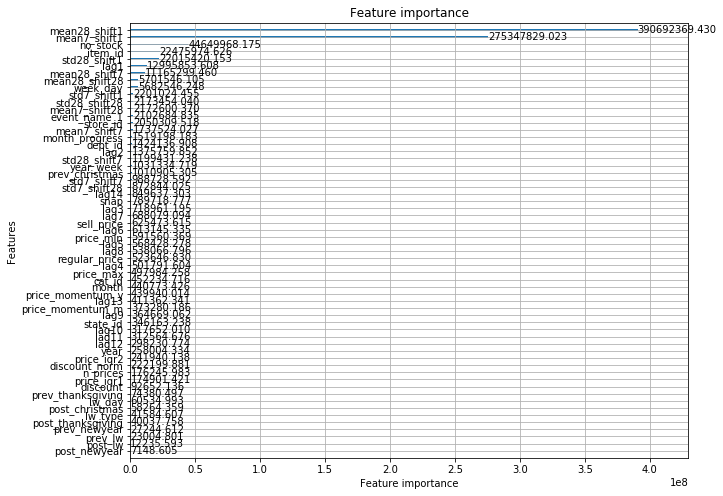

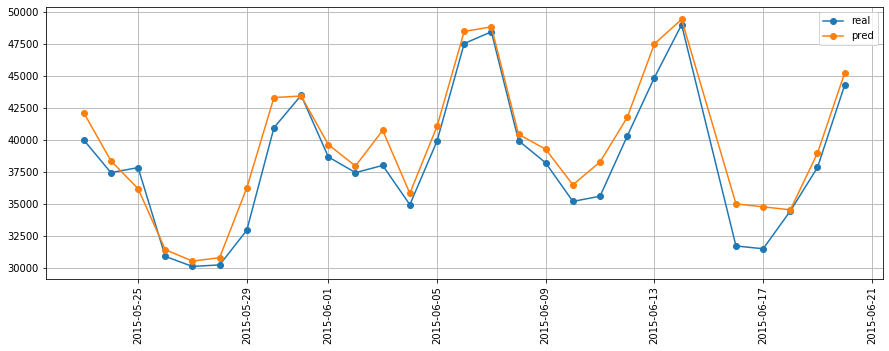

CPU times: user 1d 1h 33min 37s, sys: 2h 30min 39s, total: 1d 4h 4min 16s
Wall time: 3h 2min 2s


In [11]:
%%time

models = list()
errors = list()
best_iterations = list()

for i,valid_period in enumerate(valid_periods):
    print(f" {i+1}/{len(valid_periods)} ".center(100, "#"))
    print(f" Validation period: {valid_period} ".center(100, "#"))
    print("#"*100)
    
    valid_start = valid_period[0]
    valid_end = valid_period[1]
    
    train_start = valid_start - pd.DateOffset(days=train_history)
    _train_data = data.query("@train_start <= ds <= @valid_end").reset_index(drop=True)
    _valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

    _fcaster = LightGBMForecaster(**model_kwargs)
    _fcaster.prepare_features(train_data=_train_data, valid_index=_valid_index);
    _fcaster.train_features.dropna(inplace=True)
    _fcaster.train_features = reduce_mem_usage(_fcaster.train_features)
    _fcaster.valid_features = reduce_mem_usage(_fcaster.valid_features)
    
    if i==1:
        remove_idx = _fcaster.valid_features.query("ds == '2015-06-15'").index
        _fcaster.valid_features.drop(remove_idx, axis=0, inplace=True)

    # needed to remove leakage of 'no_stock' feature
    no_stock_ts = list()
    for threshold in [28, 56, 84, 112, 140, 168]:
        left_date = _fcaster.train_features.ds.max() - pd.DateOffset(days=threshold)
        no_stock_ts.append((_fcaster.train_features
                            .query("ds >= @left_date")
                            .groupby(["ts_id"])
                            .filter(lambda x: np.all(x.y==0))
                            .loc[:, ["ts_id"]]
                            .drop_duplicates()))
    _fcaster.valid_features["no_stock"] = 0
    for j,no_stock in enumerate(no_stock_ts):
        idx = _fcaster.valid_features.query("ts_id in @no_stock.ts_id").index
        _fcaster.valid_features.loc[idx, "no_stock"] = j+1
    
    evaluator = Evaluator(_fcaster.valid_features)
    _fcaster.fit(fit_kwargs={"verbose_eval":25, "feval":evaluator.evaluate})

    lgb.plot_importance(_fcaster.model.model, importance_type="split", figsize=(10,8))
    lgb.plot_importance(_fcaster.model.model, importance_type="gain", figsize=(10,8))
    
    errors.append(_fcaster.model.model.best_score["valid_0"]["wrmsse"])
    best_iterations.append(_fcaster.best_iteration)
    
    # visualizing the predictions at level 1
    predictions = (_fcaster.valid_features
                   .loc[:, ["ds"]+_fcaster.ts_uid_columns]
                   .assign(y_pred = _fcaster.model.predict(_fcaster.valid_features))
                  )
    mrg =  (data.loc[:, ["ds","item_id","store_id","y"]]
            .merge(predictions, how="inner", on=["ds","item_id","store_id"]))
    df = mrg.groupby(["ds"])["y","y_pred"].sum().reset_index()
    
    print("RMSE:", np.sqrt(np.mean(df.eval("(y-y_pred)**2"))))
    print("RMSSE:", np.sqrt(np.mean(df.eval("(y-y_pred)**2")))/5926.0127)
    
    plt.figure(figsize=(15,5))
    plt.plot_date(df.ds, df.y, "o-", label="real")
    plt.plot_date(df.ds, df.y_pred, "o-", label="pred")
    plt.grid()
    plt.xticks(rotation=90)
    plt.legend(loc="best")
    plt.show()
    
    del _fcaster, evaluator, _train_data, _valid_index
    gc.collect()

In [10]:
print("min",int(np.min(best_iterations)))
print("mean", int(np.mean(best_iterations)))
print("max", int(np.max(best_iterations)))

min 562
mean 798
max 1034


In [11]:
np.mean(errors)

0.5053837583494529

***
### final model

In [10]:
# 5 years of history
train_history = 1825

In [11]:
#model_kwargs["model_params"]["num_iterations"] = int(np.mean(best_iterations))
model_kwargs["model_params"]["num_iterations"] = 400
model_kwargs["model_params"]

{'objective': 'tweedie',
 'tweedie_variance_power': 1.1,
 'metric': 'None',
 'num_iterations': 400,
 'early_stopping_rounds': 300,
 'max_bin': 127,
 'bin_construct_sample_cnt': 6000000,
 'num_leaves': 1023,
 'min_data_in_leaf': 2047,
 'learning_rate': 0.05,
 'feature_fraction': 0.9,
 'bagging_fraction': 0.66,
 'bagging_freq': 1,
 'lambda_l2': 0.1,
 'seed': 7,
 'boost_from_average': False,
 'first_metric_only': True}

In [12]:
%%time
models = dict()

for store_id in tqdm(data.store_id.unique()):
    train_start = data.ds.max() - pd.DateOffset(days=train_history)
    train_data = data.query("ds >= @train_start & store_id == @store_id").reset_index(drop=True)
    
    fcaster = LightGBMForecaster(**model_kwargs)
    fcaster.prepare_features(train_data=train_data)
    fcaster.train_features.dropna(inplace=True)
    fcaster.train_features = reduce_mem_usage(fcaster.train_features)
    fcaster.fit(fit_kwargs={"verbose_eval":20})
    
    models[store_id] = fcaster
    gc.collect()

100%|██████████| 10/10 [48:37<00:00, 291.74s/it]


CPU times: user 8h 13min 33s, sys: 59min 39s, total: 9h 13min 13s
Wall time: 48min 37s


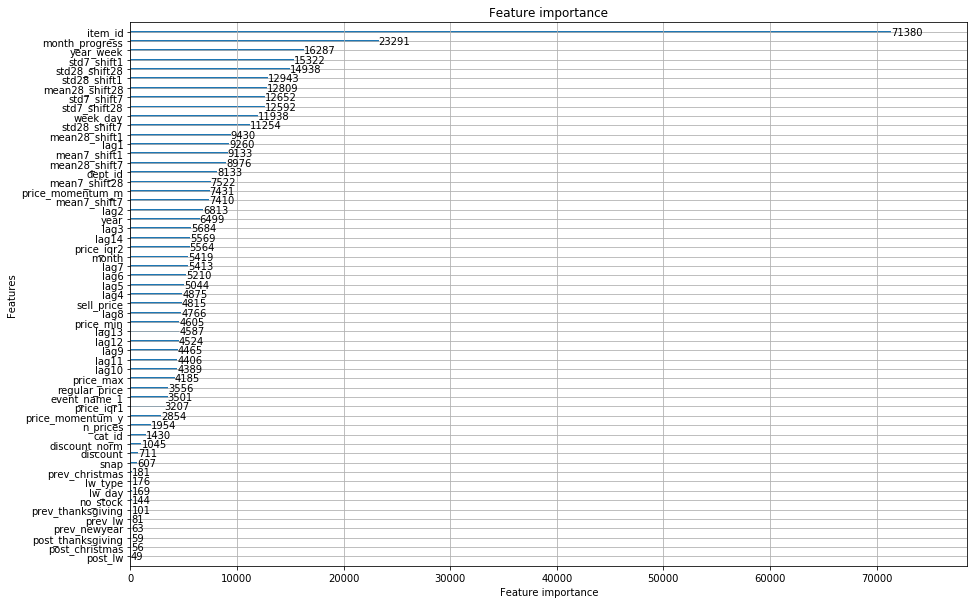

In [13]:
lgb.plot_importance(models[1].model.model, importance_type="split", figsize=(15,10));

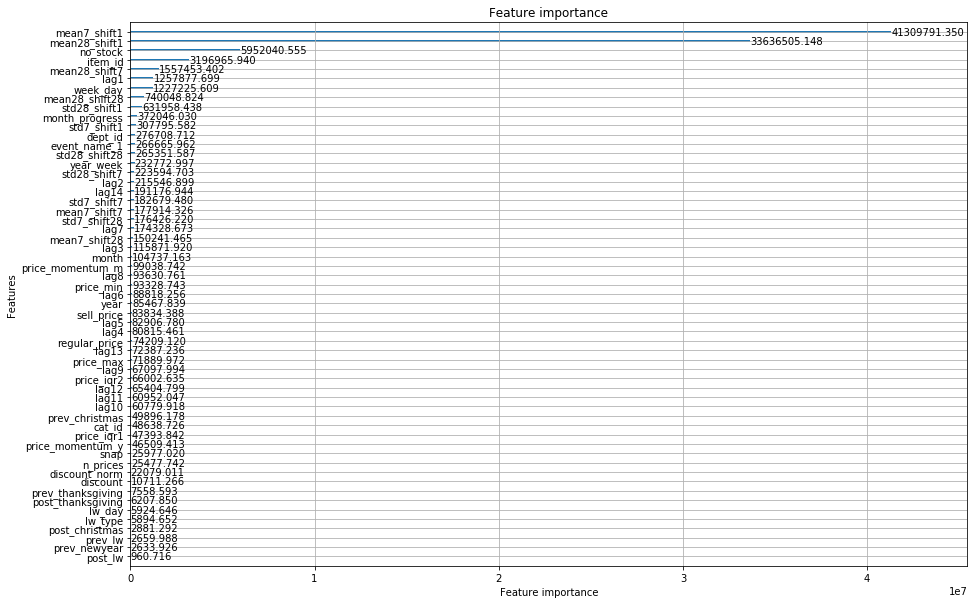

In [14]:
lgb.plot_importance(models[1].model.model, importance_type="gain", figsize=(15,10));

***
### estimating residuals

In [17]:
%%time
gc.collect()

predict_columns = list(set(fcaster.train_data.columns) - {"y"})
_train_data = fcaster.train_data
predictions = fcaster.predict(_train_data.loc[:, predict_columns])
gc.collect()

CPU times: user 8h 45min 42s, sys: 6min 11s, total: 8h 51min 54s
Wall time: 33min 31s


In [19]:
left_date = _train_data.ds.max() - pd.DateOffset(years=3)

residuals_raw = (pd.merge(_train_data, predictions, how="inner", on=["item_id","store_id","ds"])
                .query("ds >= @left_date")
                .assign(residual = lambda x: x.y - x.y_pred)
                .loc[:, ["ds","item_id","store_id","y","y_pred","residual"]])

#residuals_raw.to_parquet("../output/residuals_raw_lgbm_bottom_v95.parquet", index=False)

In [ ]:
%%time
def compute_residual_deviance(df):
    q01 = df.residual.quantile(0.01)
    q99 = df.residual.quantile(0.99)
    df["residual"] = df.query("@q01 <= residual <= @q99").residual.std()
    return df.loc[:, ["store_id","item_id","residual"]].drop_duplicates(subset=["store_id","item_id"])

residual_deviance = (residuals_raw
                     .groupby(["item_id","store_id"]).apply(compute_residual_deviance)
                     .reset_index(drop=True))

#residual_deviance.to_parquet("../output/residuals_lgbm_bottom_v95.parquet", index=False)

***
### finding optimal threshold

In [20]:
residual_raw = (pd.merge(_train_data, predictions, how="inner", on=["item_id","store_id","ds"])
                .assign(residual = lambda x: x.y - x.y_pred))
residual_raw = residual_raw.loc[:, ["ds","item_id","store_id","y","y_pred","residual"]]

In [24]:
all_fprs = list()

for threshold in np.arange(0.01, 0.501, 0.01):
    # If I want to classify all pred < threshold -> 0, how many false positives there are?
    total_samples = residual_raw.query("y_pred < @threshold")
    false_positives = total_samples.query("y > 0")
    fpr = 100*len(false_positives)/len(total_samples)
    all_fprs.append(fpr)
    print(f"threshold: {threshold} - fpr: {fpr}")

threshold: 0.01 - fpr: 0.0
threshold: 0.02 - fpr: 0.0
threshold: 0.03 - fpr: 0.0
threshold: 0.04 - fpr: 0.0
threshold: 0.05 - fpr: 0.0
threshold: 0.060000000000000005 - fpr: 0.0
threshold: 0.06999999999999999 - fpr: 1.2488799108299744e-05
threshold: 0.08 - fpr: 3.739265503555668e-05
threshold: 0.09 - fpr: 6.222794719336401e-05
threshold: 0.09999999999999999 - fpr: 0.0001616197581894907
threshold: 0.11 - fpr: 0.00023603730631741428
threshold: 0.12 - fpr: 0.0002855758257828534
threshold: 0.13 - fpr: 0.0003475159128157042
threshold: 0.14 - fpr: 0.00040944787319126404
threshold: 0.15000000000000002 - fpr: 0.0004465571559667851
threshold: 0.16 - fpr: 0.0004712760941232615
threshold: 0.17 - fpr: 0.0004959998234240629
threshold: 0.18000000000000002 - fpr: 0.0005207300138861337
threshold: 0.19 - fpr: 0.000570261412790418
threshold: 0.2 - fpr: 0.0005949980005588023
threshold: 0.21000000000000002 - fpr: 0.0006073429748824017
threshold: 0.22 - fpr: 0.0006196937944235243
threshold: 0.23 - fpr: 0.0

***
### predicting

In [27]:
valid_dataframe = pd.read_parquet("../input/valid_dataframe.parquet")
eval_dataframe = pd.read_parquet("../input/eval_dataframe.parquet")
hierarchy = pd.read_parquet("../input/hierarchy.parquet")
submission = pd.read_csv("../input/sample_submission.csv")

In [29]:
%%time
def bias_corr_func(x):
    x[x < 0.1] = 0
    return x

all_predictions = list()

for store_id in tqdm(data.store_id.unique()):
    _valid_dataframe = valid_dataframe.query("store_id == @store_id").reset_index(drop=True)
    _predictions = models[store_id].predict(_valid_dataframe, recursive=True, bias_corr_func=bias_corr_func)
    _predictions["store_id"] = store_id
    all_predictions.append(_predictions)

predictions = pd.concat(all_predictions, ignore_index=True)

100%|██████████| 10/10 [1:18:32<00:00, 471.29s/it]


CPU times: user 1h 36min 53s, sys: 6min 42s, total: 1h 43min 36s
Wall time: 1h 18min 33s


#### predictions for validation period

In [30]:
predictions_valid = pd.merge(predictions,
                             hierarchy.loc[:, ["id", "item_id", "store_id"]], 
                             how="left")
predictions_valid["id"] = predictions_valid.id.map(lambda x: x+"_validation")

In [31]:
predictions_valid.y_pred.describe()

count    853720.000000
mean          1.442220
std           3.102855
min           0.000000
25%           0.274807
50%           0.651902
75%           1.451858
max         167.424208
Name: y_pred, dtype: float64

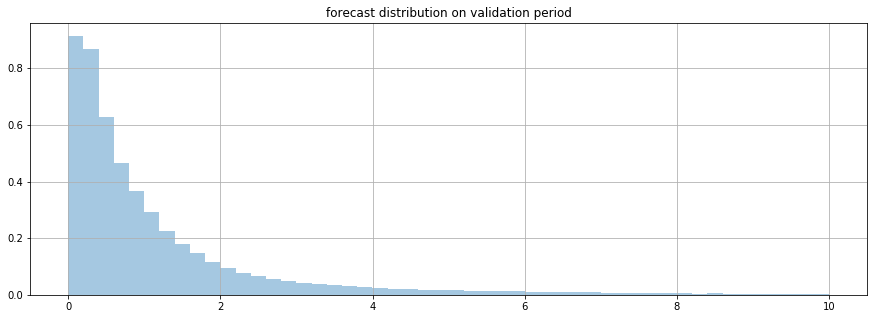

In [32]:
plt.figure(figsize=(15,5))
sns.distplot(predictions_valid.query("y_pred < 10").y_pred.values, kde=False, norm_hist=True)
plt.title("forecast distribution on validation period")
plt.grid()

In [33]:
predictions_valid = (predictions_valid
                     .pivot(index="id", columns="ds", values="y_pred")
                     .reset_index()
                     )
predictions_valid.columns = ["id"] + [f"F{i}" for i in range (1,29)]

#### predictions for evaluation period

(ommited for now)

***
### submission file

In [34]:
#assert set(predictions_valid.id) == set(submission.loc[0:30489].id), \
#    "there are missing time series predictions."

In [35]:
submission = pd.merge(submission.loc[:, ["id"]], predictions_valid, how="left", on="id").fillna(0)

In [36]:
raw_values = submission.loc[:, [f"F{i}" for i in range(1,29)]].values

submission.loc[:, [f"F{i}" for i in range(1,29)]] = raw_values

In [37]:
file_path = "../output/lgbm_bottom_v138.csv.gz"

if os.path.isfile(file_path):
    print("File already exists.")
else:
    submission.to_csv(file_path, index=False, compression="gzip")

In [38]:
!ls -halt ../output | grep .csv.gz | head -10

-rw-r--r--.  1 turing turing 7.0M May 31 04:17 lgbm_bottom_v138.csv.gz
-rw-r--r--.  1 turing turing 7.5M May 31 02:16 lgbm_bottom_v137.csv.gz
-rw-r--r--.  1 turing turing 7.0M May 30 23:30 lgbm_bottom_v136.csv.gz
-rw-r--r--.  1 turing turing 7.5M May 30 22:53 lgbm_bottom_v135.csv.gz
-rw-r--r--.  1 turing turing 6.9M May 30 21:25 lgbm_bottom_v134.csv.gz
-rw-r--r--.  1 turing turing 6.3M May 30 07:26 lgbm_bottom_v133.csv.gz
-rw-r--r--.  1 turing turing 7.1M May 29 22:40 lgbm_bottom_v132.csv.gz
-rw-r--r--.  1 turing turing 7.0M May 29 20:52 lgbm_bottom_v131.csv.gz
-rw-r--r--.  1 turing turing 7.0M May 29 12:17 lgbm_bottom_v130.csv.gz
-rw-r--r--.  1 turing turing 7.1M May 29 03:43 lgbm_bottom_v129.csv.gz


In [39]:
!kaggle competitions submit -c m5-forecasting-accuracy -f ../output/lgbm_bottom_v138.csv.gz -m ""

100%|██████████████████████████████████████| 6.90M/6.90M [00:02<00:00, 2.52MB/s]
Successfully submitted to M5 Forecasting - Accuracy

***